In [ ]:
# import libraries
import pandas as pd
import numpy as np
import time
import itertools
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from rulekit.classification import RuleClassifier, ExpertRuleClassifier
from rulekit.params import Measures
from rulekit._helpers import *
from jpype.pickle import JPickler, JUnpickler

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

import aaanalysis as aa
aa.options["verbose"] = False
aa.options["random_state"] = 42

from sklearn.model_selection import train_test_split
from src.utils import *
from src.utils_rules import *
from src.MHCRule import *

In [2]:
# seed everyhting
set_seed(42)
_ = RuleClassifier()

Jun 25, 2024 11:20:34 AM com.rapidminer.tools.I18N <clinit>
INFO: Set locale to en.


In [3]:
# read data file
BA_df = pd.read_csv('./Data/Data_HLA.csv', index_col=0)
BA_df = BA_df[BA_df['peptide_length']==9].reset_index(drop=True)

BA_df


,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,fold_0,fold_1,fold_2,fold_3,y,peptide_length
0,HLA-A*01:01,AADFPGIAR,20000.0,>,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,0,9
1,HLA-A*01:01,AADKAAAAY,50.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-A*01:01,False,True,True,True,1,9
2,HLA-A*01:01,AADSFATSY,76.3,=,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,1,9
3,HLA-A*01:01,AAFLDDNAF,20000.0,>,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,0,9
4,HLA-A*01:01,AAGLPAIFV,5000.0,>,qualitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,False,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127773,HLA-C*15:02,YVYFYDLSY,1775.0,=,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127774,HLA-C*15:02,YWMGGTTYF,20000.0,>,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127775,HLA-C*15:02,YYFSYPLFV,771.0,=,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127776,HLA-C*15:02,YYGRWVHEF,20000.0,>,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9


In [13]:
# Read count df
count_df = pd.read_csv('./Data/HLA_peptide_count.csv',index_col=0)

# HLA list
# Make sure we have atleast 10 peptides with atleast 5 +ve and -ve peptides
allele_ls = count_df[(count_df['positives']>5)&(count_df['negatives']>5)&(count_df['total']>10)]['allele'].to_list()

In [4]:
# Get hla seqs
hla_seq_df = pd.read_csv('./Data/HLA_seqs_of_interest.csv',index_col=0)


# get hla sequence dict
new_cols = hla_seq_df['Sequence'].str.split('',expand=True)
hla_seq_mat = new_cols.fillna('-').replace('','-').to_numpy()[:,1:-1]
hla_seq_dict = {hla:seq for seq,hla in zip([''.join(i) for i in hla_seq_mat], hla_seq_df['HLA_2fields'])}



In [5]:
# train pepHLA

### Create X and y

# concat peptide and hla
X_y_df = pd.DataFrame([hla_seq_dict[hla]+peptide 
             for hla, peptide in zip(BA_df['allele'], BA_df['peptide']) 
             if hla in hla_seq_dict.keys()]).rename(columns={0:'sequence'})

X_y_df['y'] = BA_df['y']

# split train, validation, test
train_df, test_df = train_test_split(X_y_df, test_size=0.3, stratify=X_y_df['y'].to_list())

# Now, splitting test data into half to get test and validation sets
test_df, valid_df = train_test_split(test_df, test_size=0.5)

 # get train
X_train, y_train = get_vector_representation(train_df['sequence']), train_df['y'].to_numpy()

# get valid
X_valid, y_valid = get_vector_representation(valid_df['sequence']), valid_df['y'].to_numpy()

# get test
X_test, y_test = get_vector_representation(test_df['sequence']), test_df['y'].to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

result = {'peptide_count':len(hla_df)}

# Start the timer
start_time = time.time()

# train classifier
pephla = MHCRulePepHLA(max_growing=0,
                             minsupp_new=13,
                             pruning_measure='C2', 
                             voting_measure='C2',
                             induction_measure='C2', 
                             complementary_conditions=False)

pephla.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

result['train_time'] = [elapsed_time]
        
### Train results
prediction = pephla.predict(X_train, return_rules=False)
prediction_proba = pephla.predict_proba( X_train, return_rules=False)

acc_, f1_, auroc, auprc = get_metric_results(y_train, prediction, 
                                             prediction_proba, 
                                             metrics=['accuracy','f1','AUROC','AUPRC'])


result['train_accuracy'], result['train_f1'] = acc_, f1_
result['train_auroc'], result['train_auprc'] = auroc, auprc

### valid results
prediction= pephla.predict( X_valid, return_rules=False)
prediction_proba= pephla.predict_proba( X_valid, return_rules=False)

acc_, f1_, auroc, auprc = get_metric_results(y_valid, prediction, 
                                             prediction_proba, 
                                             metrics=['accuracy','f1','AUROC','AUPRC'])


result['valid_accuracy'], result['valid_f1'] = acc_, f1_
result['valid_auroc'], result['valid_auprc'] = auroc, auprc

### test results
prediction = pephla.predict(X_test, return_rules=False)
prediction_proba = pephla.predict_proba(X_test, return_rules=False)

acc_, f1_, auroc, auprc = get_metric_results(y_test, prediction, 
                                             prediction_proba, 
                                             metrics=['accuracy','f1','AUROC','AUPRC'])


result['test_accuracy'], result['test_f1'] = acc_, f1_
result['test_auroc'], result['test_auprc'] = auroc, auprc
result['rule_count'] = [len(pephla.model.model.rules)]

with open('./MHCRulePepHLA.pkl', 'wb') as f:
    pickle.dump(pephla, f)
f.close()


pd.DataFrame(result).to_csv('./results/MHCRule/training_results/MMHCRulePepHLA.csv')

pd.DataFrame(result)


(89409, 375) (19160, 375) (19159, 375) (89409,) (19160,) (19159,)


# MHC-Bench-V2

In [6]:
with open('./model/MHCRulePepHLA.pkl', 'rb') as f:
    pephla = pickle.load(f)
f.close()

In [14]:
mhcbench_df = pd.read_csv('./Data/MHC-Bench_v2.csv',index_col=0)
mhcbench_df = mhcbench_df[mhcbench_df['mhc'].isin(allele_ls)]

# ensure there are no repeated peptides in training and benchmark
mhcbench_df_ls = []

for hla in mhcbench_df['mhc'].unique(): 
    BA_df_tmp = BA_df[BA_df['allele']==hla]
    mhcbench_df_tmp = mhcbench_df[mhcbench_df['mhc']==hla]
    
    mhcbench_df_tmp = mhcbench_df_tmp[~mhcbench_df_tmp['peptide'].isin(BA_df_tmp['peptide'].to_list())] 
    mhcbench_df_ls = mhcbench_df_ls + [mhcbench_df_tmp]
    
mhcbench_df = pd.concat(mhcbench_df_ls,axis=0).reset_index(drop=True)

mhcbench_df = mhcbench_df.rename(columns={'mhc':'allele', 
                                          'binding':'y'})
mhcbench_df

,peptide,allele,y
0,QIYPGIKVK,HLA-A*03:01,1
1,SFTFKEGFK,HLA-A*03:01,1
2,SLFMILCTR,HLA-A*03:01,1
3,TFFKFLADK,HLA-A*03:01,1
4,TLLRKHTLK,HLA-A*03:01,1
...,...,...,...
1395072,WRKLLKGIP,HLA-B*27:06,0
1395073,DANSYENVL,HLA-B*27:06,0
1395074,PAAMKAAAA,HLA-B*27:06,0
1395075,GKLRPACPG,HLA-B*27:06,0


In [19]:
# concat peptide and hla

result_ls = []

for allele in tqdm(mhcbench_df['allele'].unique()):
    result = {'allele':allele}
    
    hla_df = mhcbench_df[mhcbench_df['allele']==allele].reset_index(drop=True)
    
    X_y_df = pd.DataFrame([hla_seq_dict[hla]+peptide 
                 for hla, peptide in zip(hla_df['allele'], hla_df['peptide']) 
                 if hla in hla_seq_dict.keys()]).rename(columns={0:'sequence'})

    X_y_df['y'] = hla_df['y']

     # get X and y
    X_, y_ = get_vector_representation(X_y_df['sequence']), X_y_df['y'].to_numpy()

    
    result['peptide_count'] = len(X_y_df)

    ### Train results
    prediction = pephla.predict(X_, return_rules=False)
    prediction_proba = pephla.predict_proba(X_, return_rules=False)

    acc_, f1_, auroc, auprc = get_metric_results(y_, prediction, 
                                                 prediction_proba, 
                                                 metrics=['accuracy','f1','AUROC','AUPRC'])

    result['accuracy'], result['f1'] = acc_, f1_
    result['auroc'], result['auprc'] = auroc, auprc

    result['rule_count'] = [len(pephla.model.model.rules)]

    result_ls = result_ls + [pd.DataFrame(result)]


mhcbench_v2_result_df = pd.concat(result_ls)

mhcbench_v2_result_df.to_csv('./results/MHCRule/mhcbench_v2_results/MHCRulePepHLA_mhcbenchv2.csv')
mhcbench_v2_result_df

,allele,peptide_count,accuracy,f1,auroc,auprc,rule_count
0,HLA-A*03:01,4141,0.954117,0.740437,0.967485,0.726875,1674
0,HLA-A*26:01,27286,0.997031,0.000000,0.896876,0.033514,1674
0,HLA-A*32:01,47200,0.647669,0.001801,0.703588,0.000934,1674
0,HLA-B*07:02,11332,0.969996,0.000000,0.538828,0.028967,1674
0,HLA-B*27:05,4958,0.991529,0.000000,0.722548,0.019313,1674
...,...,...,...,...,...,...,...
0,HLA-B*27:04,342,0.918129,0.000000,0.485896,0.072331,1674
0,HLA-A*26:02,42,0.952381,0.000000,0.425000,0.039021,1674
0,HLA-A*69:01,194,0.886598,0.694444,0.935957,0.754345,1674
0,HLA-B*39:06,380,0.642105,0.000000,0.436581,0.309399,1674


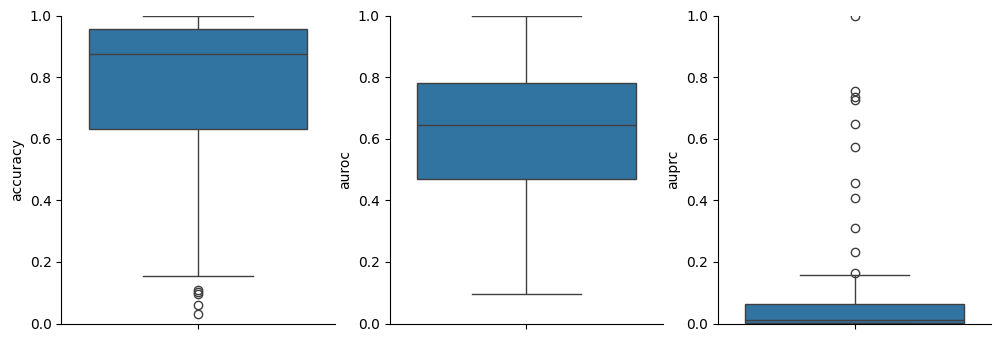

In [20]:
# Metrics

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

b = sns.boxplot(data=mhcbench_v2_result_df, y='accuracy', ax=axs[0])
b.set(ylim=(0,1))

b = sns.boxplot(data=mhcbench_v2_result_df, y='auroc', ax=axs[1])
b.set(ylim=(0,1))

b = sns.boxplot(data=mhcbench_v2_result_df, y='auprc', ax=axs[2])
b.set(ylim=(0,1))

sns.despine(top=True,right=True)


In [21]:
mhcbench_v2_result_df.median()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


peptide_count    18961.000000
accuracy             0.873997
f1                   0.001077
auroc                0.644247
auprc                0.010623
rule_count        1674.000000
dtype: float64